# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [206]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [207]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [208]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [209]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [210]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [211]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [212]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [213]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [214]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [215]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [216]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [217]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [218]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [219]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

sent_12500 = final['Text'].values[12500]
print(sent_12500)
print("="*50)

sent_85000 = final['Text'].values[85000]
print(sent_85000)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [220]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)
sent_12500 = re.sub(r"http\S+", "", sent_12500)
sent_85000 = re.sub(r"http\S+", "", sent_85000)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [221]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

soup = BeautifulSoup(sent_12500, 'lxml')
text = soup.get_text()
print(text)

soup = BeautifulSoup(sent_85000, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [222]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [223]:
sent_85000 = decontracted(sent_85000)
print(sent_85000)
print("="*50)

Great coffee at a great price!!  We were skeptical at first because it was inexpensive but this did not disappoint!  A bold flavored choice.


In [224]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [225]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_85000 = re.sub('[^A-Za-z0-9]+', ' ', sent_85000)
print(sent_85000)

Great coffee at a great price We were skeptical at first because it was inexpensive but this did not disappoint A bold flavored choice 


In [226]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [227]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [02:15<00:00, 648.11it/s]


In [228]:
preprocessed_reviews[85000]

'great coffee great price skeptical first inexpensive not disappoint bold flavored choice'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [229]:
## Similartly you can do preprocessing for review summary also.
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


# Collecting 100k rows without repetition from time_sorted_data dataframe
my_final = data.take(np.random.permutation(len(final))[:100000])
#print(my_final.shape)
# To get 2k +ve and 2k -ve reviews randomly.
#data_pos = data[data["Score"] == 1].sample(n = 200)
#data_neg = data[data["Score"] == 0].sample(n = 200)
#my_final = pd.concat([data_pos, data_neg])

#x = my_final['CleanedText'].values

In [230]:
from sklearn.model_selection import train_test_split
x = my_final['Text'].values
y = my_final['Score']

In [231]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

# [4] Featurization

### Linear SVM

### Applying Linear SVM on BOW, SET 1

In [232]:
#BoW
count_vect = CountVectorizer(max_features = 5000,min_df = 10) #in scikit-learn
#count_vect.fit(my_final)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

#final_counts = count_vect.transform(my_final)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])


X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)

### L1 reg

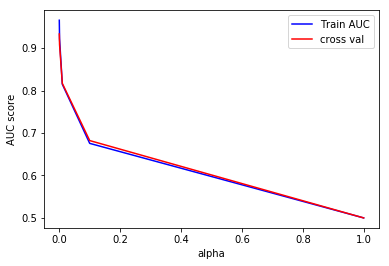

In [233]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib.legend_handler import HandlerLine2D
from sklearn.calibration import CalibratedClassifierCV
c_values = []
alpha        = 0.0001
while(alpha <= 1):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced',loss = 'hinge',penalty = 'l1',random_state=0) 
    #model.fit(X_train, y_train)
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()
plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [234]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal alpha value is: ", opt_alpha)

The optimal alpha value is:  1


In [239]:
model = SGDClassifier(alpha = opt_alpha, class_weight = 'balanced',loss = 'hinge',penalty = 'l1')
#model.fit(X_train, y_train)
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                     

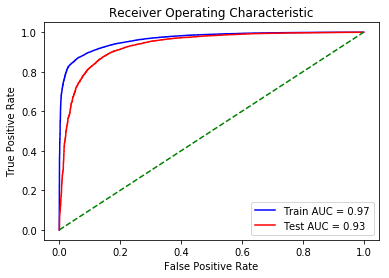

In [238]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [244]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l1')
#model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [245]:
bow_features = count_vect.get_feature_names()
log_prob = model.coef_ 
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [246]:
from sklearn.metrics import classification_report
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.83      0.68      4235
           1       0.96      0.88      0.92     22097

    accuracy                           0.87     26332
   macro avg       0.77      0.85      0.80     26332
weighted avg       0.90      0.87      0.88     26332



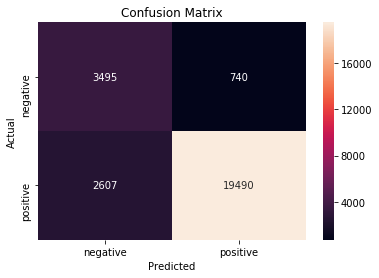

In [247]:
import seaborn as sb
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

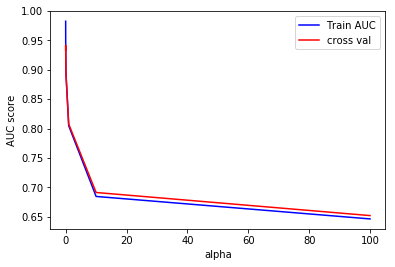

In [248]:

c_values = []
alpha        = 0.0001
while(alpha <= 100):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()


In [249]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  3


In [250]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l2')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

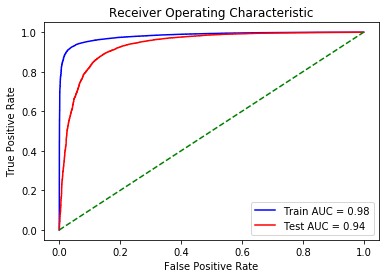

In [251]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [252]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [253]:
bow_features = count_vect.get_feature_names()
log_prob = model.coef_ 
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [254]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.60      0.85      0.70      4235
           1       0.97      0.89      0.93     22097

    accuracy                           0.88     26332
   macro avg       0.78      0.87      0.81     26332
weighted avg       0.91      0.88      0.89     26332



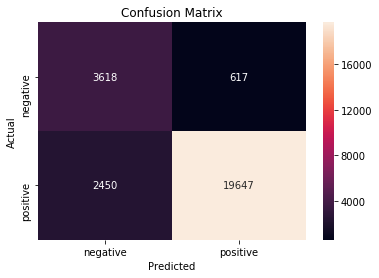

In [255]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Feature Importance

In [256]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = True)[0:10])

Top 10 Negative Features:-
 pleasantly    1.993185
amazing       1.827741
satisfied     1.742338
yummy         1.725189
amazed        1.640647
beat          1.622002
delicious     1.586123
excellent     1.569802
skeptical     1.536472
complaint     1.536409
Name: 0, dtype: float64


 Top 10 Positive Features:-
 worst            -2.491368
terrible         -1.955934
shame            -1.881394
disappointing    -1.781743
hopes            -1.739343
awful            -1.723006
horrible         -1.701307
disappointment   -1.663976
cancelled        -1.660816
distilled        -1.617559
Name: 0, dtype: float64


### Applying Linear SVM on TFIDF, SET 2

In [257]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [258]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)


#print("the type of count vectorizer ",type(final_tf_idf))
#print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

### L1 reg

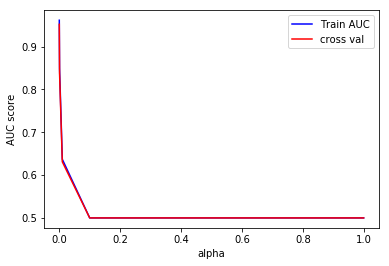

In [260]:

c_values = []
alpha        = 0.0001
while(alpha <= 1):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()


In [261]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  1


In [262]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l2')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

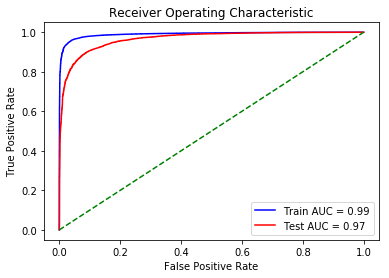

In [263]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [264]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [265]:
bow_features = tfidf_vect.get_feature_names()
log_prob = model.coef_ 
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [266]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.58      0.88      0.70      4235
           1       0.97      0.88      0.92     22097

    accuracy                           0.88     26332
   macro avg       0.78      0.88      0.81     26332
weighted avg       0.91      0.88      0.89     26332



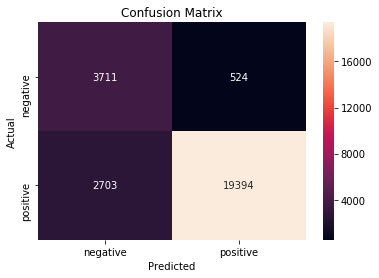

In [267]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

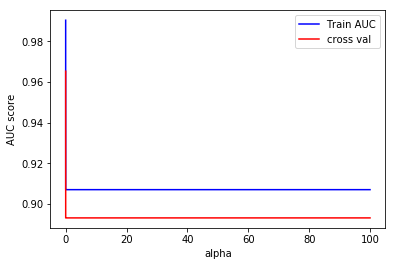

In [268]:

c_values = []
alpha        = 0.0001
while(alpha <= 100):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [269]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  1


In [270]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l2')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

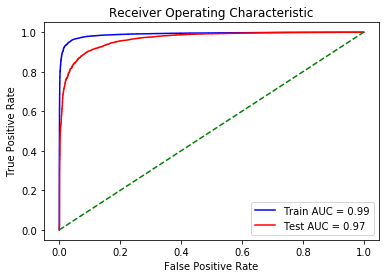

In [271]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [273]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [274]:
bow_features = tfidf_vect.get_feature_names()
log_prob = model.coef_ 
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [275]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.65      0.89      0.76      4235
           1       0.98      0.91      0.94     22097

    accuracy                           0.91     26332
   macro avg       0.82      0.90      0.85     26332
weighted avg       0.93      0.91      0.91     26332



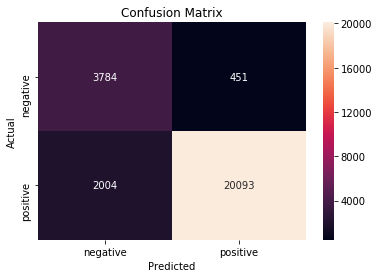

In [276]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Feature Importance

In [277]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = True)[0:10])

Top 10 Negative Features:-
 great        5.593841
delicious    4.303405
good         3.714853
the best     3.393497
perfect      3.362319
best         3.224859
nice         3.164940
excellent    3.059917
not too      2.888390
love         2.869981
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not             -4.454696
disappointed    -3.131377
awful           -3.104140
terrible        -2.916941
horrible        -2.733745
disappointing   -2.685511
not worth       -2.674624
bad             -2.609059
worst           -2.543513
unfortunately   -2.542035
Name: 0, dtype: float64


###  Applying Linear SVM on AVG W2V, SET 3

In [278]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [279]:
def standardize(data):    
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler()
    std = scalar.fit_transform(data)
    return (std)

word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) 
print("The size of the corpus is: ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) 
word2vec_words = list(word2vec_model.wv.vocab)                                       

def vect_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    sent_vectors = []; 
    for sentence in tqdm(word2vec_corpus): 
        sent_vec = np.zeros(200) 
        count_words =0; 
        for word in sentence: 
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] 
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train = vect_w2v(X_train, word2vec_model, word2vec_words)
X_test = vect_w2v(X_test, word2vec_model, word2vec_words)
X_cv = vect_w2v(X_cv, word2vec_model, word2vec_words)

X_train = standardize(X_train)
X_test = standardize(X_test)
X_cv = standardize(X_cv)

The size of the corpus is:  43008


100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [09:25<00:00, 32.61it/s]


### L1 reg

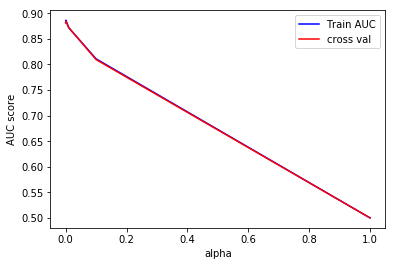

In [281]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib.legend_handler import HandlerLine2D
from sklearn.calibration import CalibratedClassifierCV
c_values = []
alpha        = 0.0001
while(alpha <= 1):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [282]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  3


In [283]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l1')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

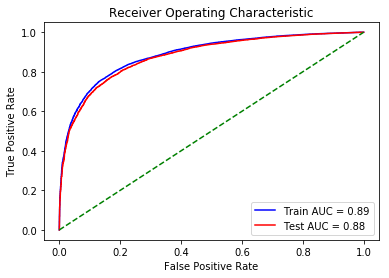

In [284]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [285]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [286]:
from sklearn.metrics import classification_report
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.40      0.82      0.54      4235
           1       0.96      0.76      0.85     22097

    accuracy                           0.77     26332
   macro avg       0.68      0.79      0.69     26332
weighted avg       0.87      0.77      0.80     26332



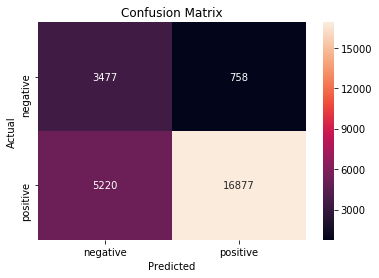

In [287]:
import seaborn as sb

conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

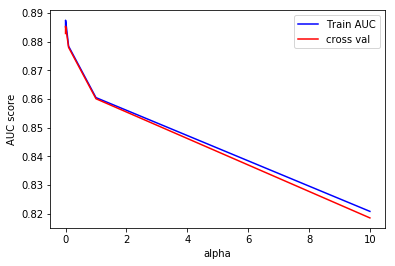

In [288]:

c_values = []
alpha        = 0.0001
while(alpha <= 10):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha=C,class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [289]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  3


In [290]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l2')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

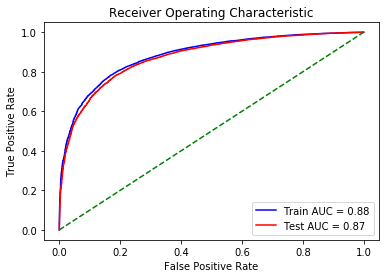

In [291]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [292]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [293]:
from sklearn.metrics import classification_report
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.42      0.80      0.55      4235
           1       0.95      0.79      0.86     22097

    accuracy                           0.79     26332
   macro avg       0.69      0.80      0.71     26332
weighted avg       0.87      0.79      0.81     26332



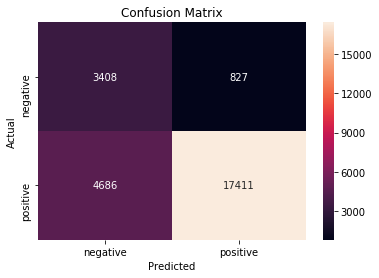

In [294]:
import seaborn as sb
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Applying Linear SVM on TFIDF W2V, SET 4

In [295]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [296]:
word2vec_corpus = []
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

word2vec_model = Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

tf_idf = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)


def vect_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))
    
    tfidf_sent_vectors = []; 
    row=0;
    for sentence in tqdm(word2vec_corpus): 
        sent_vec = np.zeros(200) 
        weight_sum = 0;
        for word in sentence: 
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) 
                sent_vec += (word_vectors * tf_idf)                           
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors


X_train = vect_tfidf_w2v(X_train, tf_idf, word2vec_model, word2vec_words)
X_test  = vect_tfidf_w2v(X_test, tf_idf, word2vec_model, word2vec_words)
X_cv    = vect_tfidf_w2v(X_cv, tf_idf, word2vec_model, word2vec_words)


X_train = standardize(X_train)
X_test  = standardize(X_test)
X_cv    = standardize(X_cv)

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [42:14<00:00,  7.27it/s]


### L1 reg

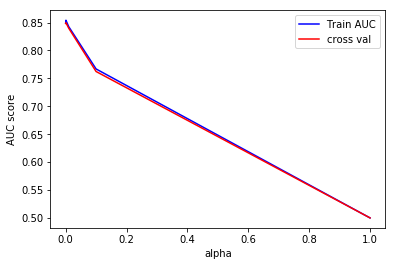

In [297]:

c_values = []
alpha        = 0.0001
while(alpha <= 1):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha=C,class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [298]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  3


In [299]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l1')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

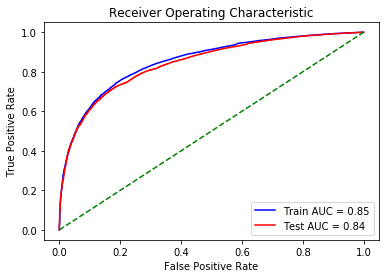

In [300]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [301]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l1')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [302]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.35      0.79      0.49      4235
           1       0.95      0.72      0.82     22097

    accuracy                           0.73     26332
   macro avg       0.65      0.76      0.66     26332
weighted avg       0.85      0.73      0.77     26332



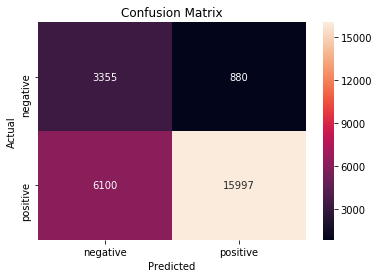

In [303]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

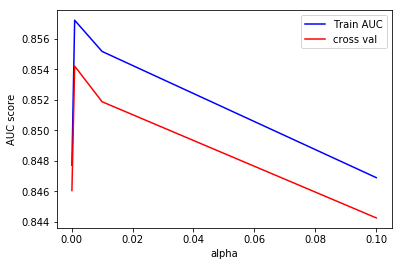

In [304]:

c_values = []
alpha        = 0.0001
while(alpha <= 0.1):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SGDClassifier(alpha = C,class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()





In [305]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_alpha = a*2 + 1  
print("The optimal k value is: ", opt_alpha)

The optimal k value is:  3


In [306]:
model = SGDClassifier(class_weight = 'balanced',loss = 'hinge',penalty = 'l2')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                

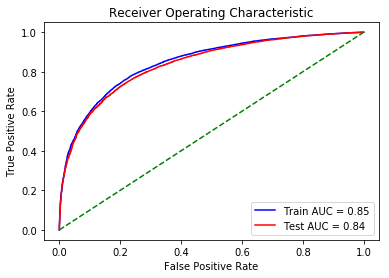

In [307]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [308]:
model = SGDClassifier(class_weight = 'balanced', loss = 'hinge',penalty = 'l2')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [309]:

print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.36      0.77      0.49      4235
           1       0.94      0.73      0.83     22097

    accuracy                           0.74     26332
   macro avg       0.65      0.75      0.66     26332
weighted avg       0.85      0.74      0.77     26332



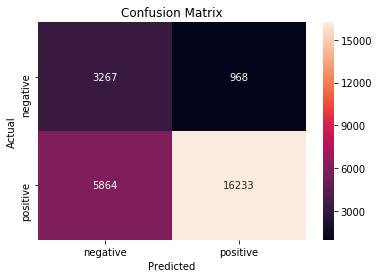

In [310]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RBF SVM

In [311]:
## Similartly you can do preprocessing for review summary also.
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


# Collecting 100k rows without repetition from time_sorted_data dataframe
my_final = data.take(np.random.permutation(len(final))[:40000])
#print(my_final.shape)
# To get 2k +ve and 2k -ve reviews randomly.
#data_pos = data[data["Score"] == 1].sample(n = 200)
#data_neg = data[data["Score"] == 0].sample(n = 200)
#my_final = pd.concat([data_pos, data_neg])

#x = my_final['CleanedText'].values

In [312]:
from sklearn.model_selection import train_test_split
x = my_final['Text'].values
y = my_final['Score']

In [313]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

### Applying Linear SVM on BOW, SET 1

In [314]:
#BoW
count_vect = CountVectorizer(max_features = 5000,min_df = 10) #in scikit-learn
#count_vect.fit(my_final)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

#final_counts = count_vect.transform(my_final)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])


X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)

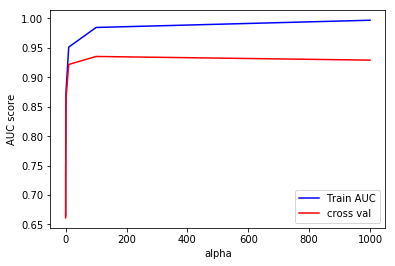

In [315]:


c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SVC(C = C,class_weight = 'balanced', kernel='rbf', gamma='auto')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [316]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_C = a*2 + 1  
print("The optimal opt_C value is: ", opt_C)

The optimal opt_C value is:  13


In [317]:
model = SVC(C= opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

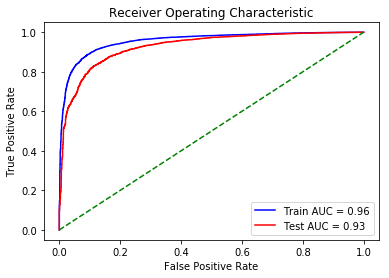

In [318]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [319]:
model = SVC(C = opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [320]:
bow_features = count_vect.get_feature_names()
log_prob = model.support_  
#feature_prob = pd.DataFrame(log_prob, columns = bow_features)
#feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [321]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.85      0.68      1956
           1       0.97      0.87      0.92     10044

    accuracy                           0.87     12000
   macro avg       0.77      0.86      0.80     12000
weighted avg       0.90      0.87      0.88     12000



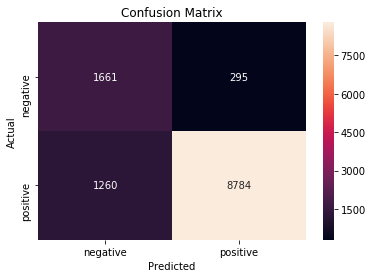

In [322]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Feature Importance

In [323]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = True)[0:10])

Top 10 Negative Features:-
 great        5.593841
delicious    4.303405
good         3.714853
the best     3.393497
perfect      3.362319
best         3.224859
nice         3.164940
excellent    3.059917
not too      2.888390
love         2.869981
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not             -4.454696
disappointed    -3.131377
awful           -3.104140
terrible        -2.916941
horrible        -2.733745
disappointing   -2.685511
not worth       -2.674624
bad             -2.609059
worst           -2.543513
unfortunately   -2.542035
Name: 0, dtype: float64


### Applying RBF SVM on TFIDF, SET 2

In [324]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [325]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features = 500)

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)


#print("the type of count vectorizer ",type(final_tf_idf))
#print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

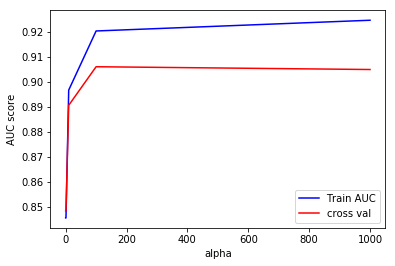

In [326]:


c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SVC(C = C,class_weight = 'balanced', kernel='rbf', gamma='auto')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()


In [327]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_C = a*2 + 1  
print("The optimal opt_C value is: ", opt_C)

The optimal opt_C value is:  13


In [328]:
model = SVC(C= opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=13, cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='auto', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv='warn', method='sigmoid')

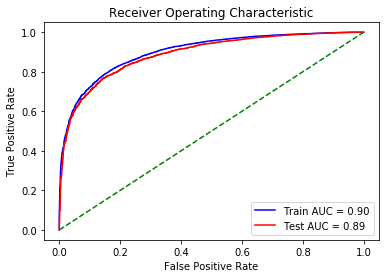

In [329]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [330]:
model = SVC(C= opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [331]:
bow_features = tfidf_vect.get_feature_names()
log_prob = model.support_  
#feature_prob = pd.DataFrame(log_prob, columns = bow_features)
#feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [332]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.44      0.84      0.58      1956
           1       0.96      0.79      0.87     10044

    accuracy                           0.80     12000
   macro avg       0.70      0.81      0.72     12000
weighted avg       0.88      0.80      0.82     12000



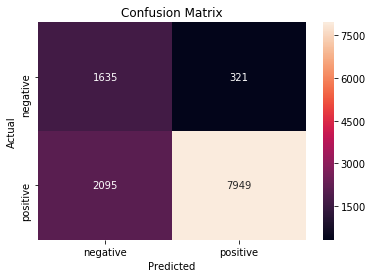

In [333]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [334]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = True)[0:10])

Top 10 Negative Features:-
 great        5.593841
delicious    4.303405
good         3.714853
the best     3.393497
perfect      3.362319
best         3.224859
nice         3.164940
excellent    3.059917
not too      2.888390
love         2.869981
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not             -4.454696
disappointed    -3.131377
awful           -3.104140
terrible        -2.916941
horrible        -2.733745
disappointing   -2.685511
not worth       -2.674624
bad             -2.609059
worst           -2.543513
unfortunately   -2.542035
Name: 0, dtype: float64


### Applying RBF SVM on AVG W2V, SET 3

In [335]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [336]:
def standardize(data):    
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler()
    std = scalar.fit_transform(data)
    return (std)

word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) 
print("The size of the corpus is: ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) 
word2vec_words = list(word2vec_model.wv.vocab)                                       

def vect_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    sent_vectors = []; 
    for sentence in tqdm(word2vec_corpus): 
        sent_vec = np.zeros(200) 
        count_words =0; 
        for word in sentence: 
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] 
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train = vect_w2v(X_train, word2vec_model, word2vec_words)
X_test = vect_w2v(X_test, word2vec_model, word2vec_words)
X_cv = vect_w2v(X_cv, word2vec_model, word2vec_words)

X_train = standardize(X_train)
X_test = standardize(X_test)
X_cv = standardize(X_cv)

The size of the corpus is:  19600


100%|██████████████████████████████████████████████████████████████████████████████| 8400/8400 [01:35<00:00, 87.52it/s]


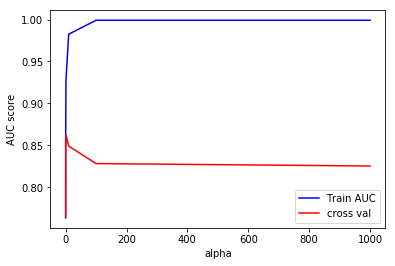

In [337]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SVC(C=C,class_weight = 'balanced', kernel='rbf', gamma='auto')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [338]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_C = a*2 + 1  
print("The optimal opt_C value is: ", opt_C)

The optimal opt_C value is:  9


In [339]:
model = SVC(C= opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=9, cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='auto', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv='warn', method='sigmoid')

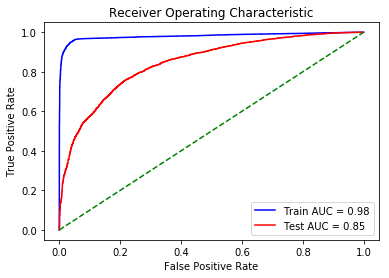

In [340]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [341]:
model = SVC(C = opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [342]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.46      0.62      0.53      1956
           1       0.92      0.86      0.89     10044

    accuracy                           0.82     12000
   macro avg       0.69      0.74      0.71     12000
weighted avg       0.85      0.82      0.83     12000



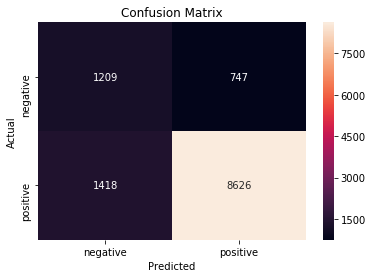

In [343]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Applying Linear SVM on TFIDF W2V, SET 4

In [344]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [345]:
word2vec_corpus = []
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

word2vec_model = Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

tf_idf = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)


def vect_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))
    
    tfidf_sent_vectors = []; 
    row=0;
    for sentence in tqdm(word2vec_corpus): 
        sent_vec = np.zeros(200) 
        weight_sum = 0;
        for word in sentence: 
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) 
                sent_vec += (word_vectors * tf_idf)                           
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors


X_train = vect_tfidf_w2v(X_train, tf_idf, word2vec_model, word2vec_words)
X_test  = vect_tfidf_w2v(X_test, tf_idf, word2vec_model, word2vec_words)
X_cv    = vect_tfidf_w2v(X_cv, tf_idf, word2vec_model, word2vec_words)


X_train = standardize(X_train)
X_test  = standardize(X_test)
X_cv    = standardize(X_cv)

100%|██████████████████████████████████████████████████████████████████████████████| 8400/8400 [15:31<00:00,  9.02it/s]


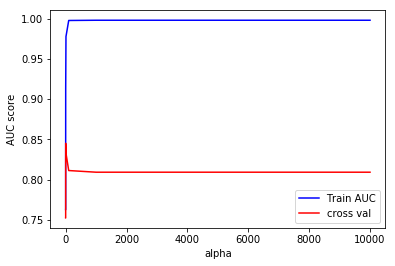

In [346]:
c_values = []
alpha        = 0.0001
while(alpha <= 10000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = SVC(C=C,class_weight = 'balanced', kernel='rbf', gamma='auto')
    model = CalibratedClassifierCV(model, method='sigmoid')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()

In [347]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_C = a*2 + 1  
print("The optimal opt_C value is: ", opt_C)

The optimal opt_C value is:  9


In [348]:
model = SVC(C= opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model = CalibratedClassifierCV(model, method='sigmoid')
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=9, cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='auto', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv='warn', method='sigmoid')

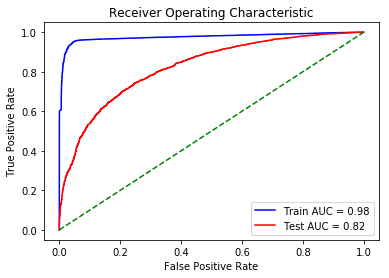

In [349]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [350]:
model = SVC(C = opt_C,class_weight = 'balanced', kernel='rbf', gamma='auto')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [351]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.43      0.59      0.50      1956
           1       0.91      0.85      0.88     10044

    accuracy                           0.80     12000
   macro avg       0.67      0.72      0.69     12000
weighted avg       0.84      0.80      0.82     12000



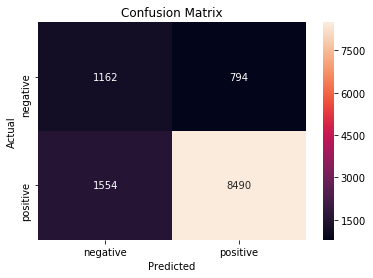

In [352]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Conclusions

### Linear SVM

In [353]:
from prettytable import PrettyTable
x1 = PrettyTable()
x1.field_names = ["Type","Model", "AUC"]
x1.add_row(["Bag of Words","Linear SVM",0.94])
x1.add_row(["TF-IDF","Linear SVM",0.97])
x1.add_row(["AvgW2V","Linear SVM",0.88])
x1.add_row(["TfidfAvgW2v","Linear SVM",0.84])

print(x1)

+--------------+------------+------+
|     Type     |   Model    | AUC  |
+--------------+------------+------+
| Bag of Words | Linear SVM | 0.94 |
|    TF-IDF    | Linear SVM | 0.97 |
|    AvgW2V    | Linear SVM | 0.88 |
| TfidfAvgW2v  | Linear SVM | 0.84 |
+--------------+------------+------+


### RBF SVM

In [354]:
x2 = PrettyTable()
x2.field_names = ["Type","Model", "AUC"]
x2.add_row(["Bag of Words","RBF SVM",0.93])
x2.add_row(["TF-IDF","RBF SVM",0.89])
x2.add_row(["AvgW2V","RBF SVM",0.85])
x2.add_row(["TfidfAvgW2v","RBF SVM",0.82])

print(x2)

+--------------+---------+------+
|     Type     |  Model  | AUC  |
+--------------+---------+------+
| Bag of Words | RBF SVM | 0.93 |
|    TF-IDF    | RBF SVM | 0.89 |
|    AvgW2V    | RBF SVM | 0.85 |
| TfidfAvgW2v  | RBF SVM | 0.82 |
+--------------+---------+------+
